# SpaceRocks

### Vectorized coordinate transformation and ephemeris calculation with robust unit handling.

To install, simply `pip install spacerocks`

In [1]:
from spacerocks import Units, SpaceRock, Observe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy import units as u
%matplotlib inline

from astroquery.jplhorizons import Horizons

In [20]:
TNO = SpaceRock(a=4.487673062316562E+02,
                e=9.214543710796702E-01,
                inc=5.411068217470999E+01,
                arg=3.480587931444684E+02,
                node=1.352131434907198E+02,
                t_peri=2473015.776611103211,
                epoch=2458982.5,
                input_frame='barycentric',
                units=units)

In [24]:
TNO.x, TNO.y, TNO.z, TNO.vx, TNO.vy, TNO.vz

(<Distance [15.80639409] AU>,
 <Distance [26.34085915] AU>,
 <Distance [-41.22486402] AU>,
 <Quantity [-0.00265435] AU / d>,
 <Quantity [0.00083059] AU / d>,
 <Quantity [0.00176952] AU / d>)

In [28]:
TNO.position.z

<Distance [-41.22486402] AU>

You can also pass in just a single object or an array of objects. I'll try all of the TNOs reported to the MPC. I specified an observatory code, so a topocentric correction will be applied to the Earth's position.

### Analyzing all of the TNOs in the MPC

In [2]:
units = Units()

In [3]:
Nyears = 1
startdate = Time('2021-01-01', scale='utc', format='iso')
testdates = Time(np.arange(startdate.jd, startdate.jd + Nyears*365.25, 10), scale='utc', format='jd' )
tno_id = '2015 BP519'
TNO_Horizons = Horizons(id=tno_id, location='@ssb')
elements = TNO_Horizons.elements()[0]
ephem_Horizons = Horizons(id=tno_id, location='geocentric',
                          epochs={'start':testdates[0].iso, 'stop':testdates[-1].iso, 'step':'10d'}).ephemerides()

In [4]:
TNO = SpaceRock(a=elements['a'],
                e=elements['e'],
                inc=elements['incl'],
                arg=elements['w'],
                node=elements['Omega'],
                t_peri=elements['Tp_jd'],
                epoch=elements['datetime_jd'],
                name=[tno_id],
                input_frame='barycentric',
                units=units)

In [5]:
TNO_prop = TNO.propagate(obsdates=testdates.jd, model=6)
#TNO_prop.to_helio()

/home/kevin/.local/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [6]:
epochs = {'start':testdates[0].iso, 'stop':testdates[-1].iso, 'step':'10d'}
elem = Horizons(id=tno_id, epochs=epochs, location='@ssb').elements()

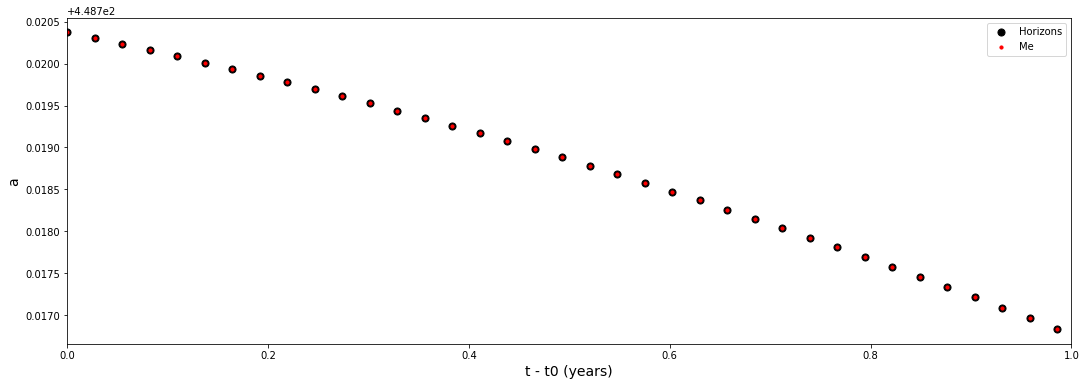

In [7]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter((testdates.jd - testdates.jd[0])/365.25, elem['a'], color='black', s=50, label='Horizons')
ax.scatter((testdates.jd - testdates.jd[0])/365.25, TNO_prop.a, color='red', s=10, label='Me')
ax.set_xlabel('t - t0 (years)', fontsize=14)
ax.set_ylabel('a', fontsize=14)
ax.set_xlim([0, Nyears])
ax.legend();

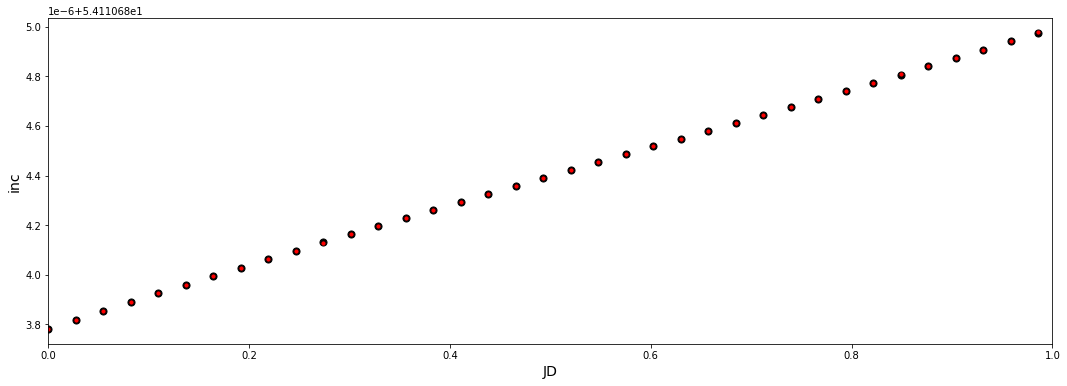

In [8]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter((testdates.jd - testdates.jd[0])/365.25, elem['incl'], color='black', s=50)
ax.scatter((testdates.jd - testdates.jd[0])/365.25, TNO_prop.inc.deg, color='red', s=10)
ax.set_xlabel('JD', fontsize=14)
ax.set_ylabel('inc', fontsize=14)
ax.set_xlim([0, Nyears]);

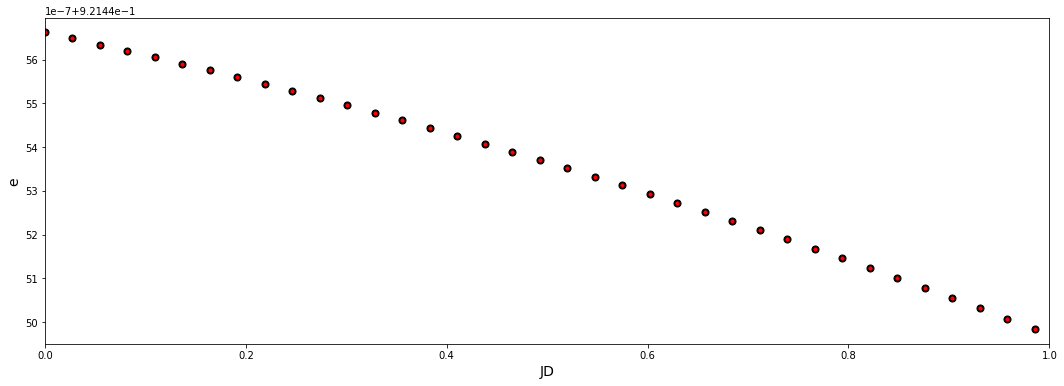

In [9]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter((testdates.jd - testdates.jd[0])/365.25, elem['e'], color='black', s=50)
ax.scatter((testdates.jd - testdates.jd[0])/365.25, TNO_prop.e, color='red', s=10)
ax.set_xlabel('JD', fontsize=14)
ax.set_ylabel('e', fontsize=14)
ax.set_xlim([0, Nyears]);

(0.0, 1.0)

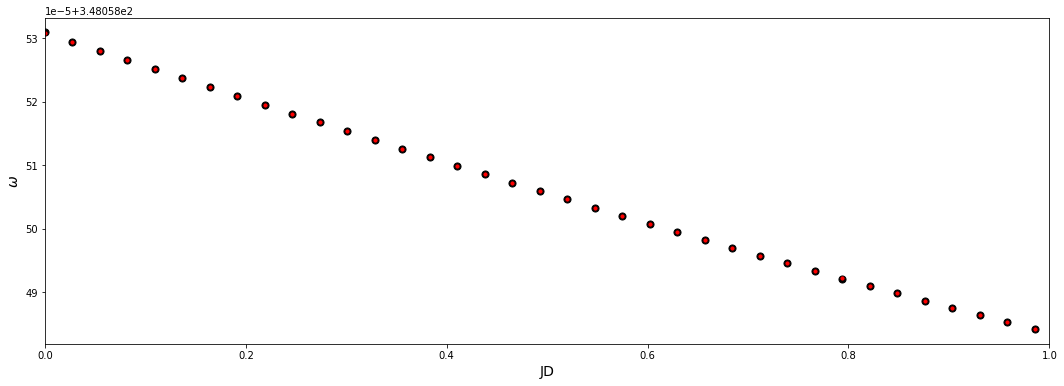

In [10]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter((testdates.jd - testdates.jd[0])/365.25, elem['w'], color='black', s=50)
ax.scatter((testdates.jd - testdates.jd[0])/365.25, TNO_prop.arg.deg, color='red', s=10)
ax.set_xlabel('JD', fontsize=14)
ax.set_ylabel(r'$\omega$', fontsize=14)
ax.set_xlim([0, Nyears])

In [11]:
TNO_prop.frame

'barycentric'

In [29]:
from skyfield.api import Topos, Loader
# Load in planets for ephemeride calculation.
load = Loader('./Skyfield-Data', expire=False, verbose=False)
ts = load.timescale()
planets = load('de423.bsp')

In [31]:
t = ts.tt(jd=TNO_prop.epoch.tt.jd)
earth = planets['earth']

ee = earth.at(t)

In [37]:
xx, yy, zz = ee.position.au

In [12]:
TNO_predict = Observe(TNO_prop)

/home/kevin/.local/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in arccos
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [13]:
pos_Horizons = SkyCoord(ephem_Horizons['RA'], ephem_Horizons['DEC'], frame='icrs', unit=(u.deg, u.deg))
pos_pred = SkyCoord(TNO_predict.ra.deg, TNO_predict.dec.deg, frame='icrs', unit=(u.deg, u.deg))
sep = pos_pred.separation(pos_Horizons)

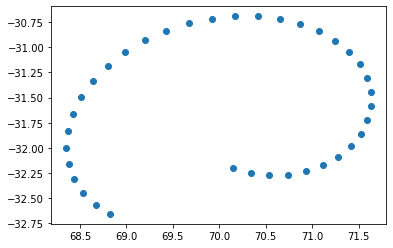

In [14]:
plt.scatter(ephem_Horizons['RA'], ephem_Horizons['DEC'])
#plt.scatter(TNO_predict.ra.deg, TNO_predict.dec.deg)

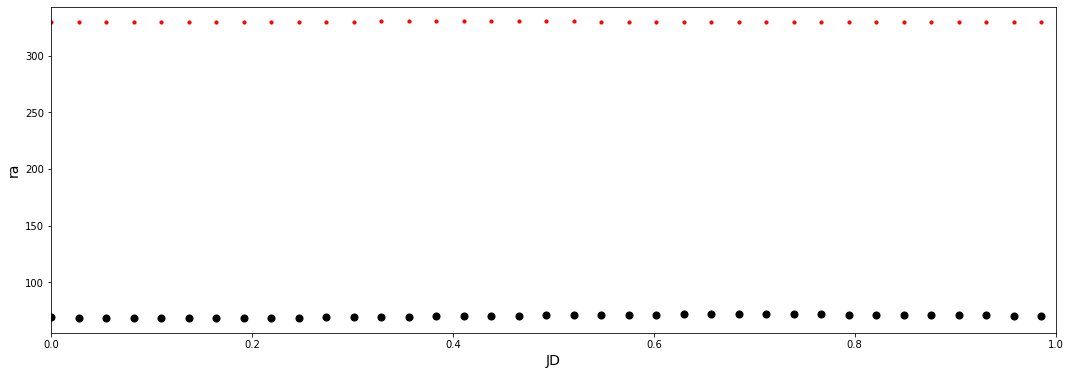

In [15]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter((testdates.jd - testdates.jd[0])/365.25, ephem_Horizons['RA'], color='black', s=50)
ax.scatter((testdates.jd - testdates.jd[0])/365.25, TNO_predict.ra.deg, color='red', s=10)
ax.set_xlabel('JD', fontsize=14)
ax.set_ylabel('ra', fontsize=14)
ax.set_xlim([0, Nyears]);

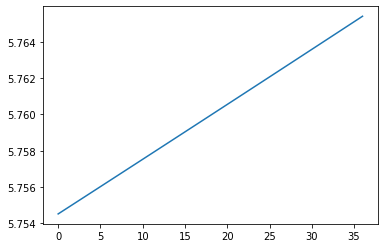

In [47]:
plt.plot(TNO_prop.M)

In [39]:
restra = np.arctan2(TNO_prop.y.au -yy, TNO_prop.x.au -xx)

In [45]:
ephem_Horizons

targetname,datetime_str,datetime_jd,H,G,solar_presence,flags,RA,DEC,RA_app,DEC_app,RA_rate,DEC_rate,AZ,EL,AZ_rate,EL_rate,sat_X,sat_Y,sat_PANG,siderealtime,airmass,magextinct,V,surfbright,illumination,illum_defect,sat_sep,sat_vis,ang_width,PDObsLon,PDObsLat,PDSunLon,PDSunLat,SubSol_ang,SubSol_dist,NPole_ang,NPole_dist,EclLon,EclLat,r,r_rate,delta,delta_rate,lighttime,vel_sun,vel_obs,elong,elongFlag,alpha,lunar_elong,lunar_illum,sat_alpha,sunTargetPA,velocityPA,OrbPlaneAng,constellation,TDB-UT,ObsEclLon,ObsEclLat,NPole_RA,NPole_DEC,GlxLon,GlxLat,solartime,earth_lighttime,RA_3sigma,DEC_3sigma,SMAA_3sigma,SMIA_3sigma,Theta_3sigma,Area_3sigma,RSS_3sigma,r_3sigma,r_rate_3sigma,SBand_3sigma,XBand_3sigma,DoppDelay_3sigma,true_anom,hour_angle,alpha_true,PABLon,PABLat
---,---,d,mag,---,---,---,deg,deg,deg,deg,arcsec / h,arcsec / h,deg,deg,arcsec / min,arcsec / min,arcsec,arcsec,deg,---,---,mag,mag,mag / arcsec2,%,arcsec,arcsec,---,arcsec,deg,deg,deg,deg,deg,arcsec,deg,arcsec,deg,deg,AU,km / s,AU,km / s,min,km / s,km / s,deg,---,deg,deg,%,deg,deg,deg,deg,---,s,deg,deg,deg,deg,deg,deg,---,min,arcsec,arcsec,arcsec,arcsec,deg,arcsec2,arcsec,km,km / s,Hz,Hz,s,deg,---,deg,deg,deg
str12,str17,float64,float64,float64,str1,str1,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,int64,int64,int64,float64,int64,float64,int64,float64,str1,int64,int64,int64,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str2,float64,float64,float64,float64,float64,float64,float64,str3,float64,float64,float64,int64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64
(2015 BP519),2021-Jan-01 00:00,2459215.5,4.4,0.15,,,68.82375,-32.65638,69.02586,-32.61661,-2.11927,1.204746,--,--,--,--,488136.541,-34622.57,149.522,--,999,--,21.609,--,99.99253,--,418404.7,*,--,--,--,--,--,213.34,0.0,--,--,60.1959,-53.1642,50.99070413165,-3.1100078,50.5486536223433,8.6690557,420.4003329,5.7252814,26.2949691,116.2235,/T,0.9893,77.7,96.3041,62.7864,33.548,244.99,0.51388,Eri,69.183909,59.2719817,-53.8390082,--,--,233.759562,-41.71145,--,0.0,6.049,2.849,6.492,1.6,22.002,65.26,6.687,2948023.45,0.0181236,295.26,1073.12,19.667096,290.9007,--,0.9904,59.5891,-53.503
(2015 BP519),2021-Jan-11 00:00,2459225.5,4.4,0.15,,,68.66721,-32.56379,68.86925,-32.52435,-1.81741,1.575493,--,--,--,--,455235.46,-38602.35,141.173,--,999,--,21.614,--,99.99195,--,401136.1,*,--,--,--,--,--,223.37,0.0,--,--,60.2468,-53.1576,50.97274494022,-3.109309,50.6053247534086,10.8918133,420.87165233,5.7264847,26.8310021,111.4267,/T,1.0272,122.8,6.2986,67.5452,43.545,244.98,0.37401,Eri,69.184202,59.0929861,-53.7176095,--,--,233.610462,-41.82813,--,0.0,5.919,2.952,6.418,1.6,23.528,64.5,6.614,2962643.89,0.0181273,292.92,1064.6,19.764633,290.9376,--,1.0283,59.5254,-53.4393
(2015 BP519),2021-Jan-21 00:00,2459235.5,4.4,0.15,,,68.53766,-32.44789,68.73953,-32.40868,-1.44196,1.899317,--,--,--,--,424330.039,-45035.07,134.227,--,999,--,21.62,--,99.9914,--,381874.4,*,--,--,--,--,--,232.68,0.0,--,--,60.2976,-53.151,50.9547899001,-3.1086122,50.6735840946331,12.6611668,421.43934796,5.7276951,27.4395022,106.0762,/T,1.0615,54.3,51.3045,72.8613,52.832,244.948,0.22272,Eri,69.184492,58.9611337,-53.5789299,--,--,233.43466,-41.918933,--,0.0,5.814,3.084,6.384,1.603,25.241,64.29,6.582,2977151.6,0.0181302,290.3,1055.1,19.861418,290.9747,--,1.0624,59.4847,-53.367
(2015 BP519),2021-Jan-31 00:00,2459245.5,4.4,0.15,,,68.44009,-32.3123,68.64176,-32.27328,-1.01371,2.163749,--,--,--,--,394624.982,-53617.06,128.753,--,999,--,21.625,--,99.99096,--,361280.2,*,--,--,--,--,--,241.43,0.0,--,--,60.3485,-53.1443,50.93683896657,-3.107918,50.7506013004658,13.926421,422.07988052,5.7289077,28.1202155,100.3556,/T,1.0886,100.2,94.04,78.5549,61.552,244.894,0.06501,Eri,69.184761,58.8816739,-53.4275819,--,--,233.237829,-41.980078,--,0.0,5.742,3.

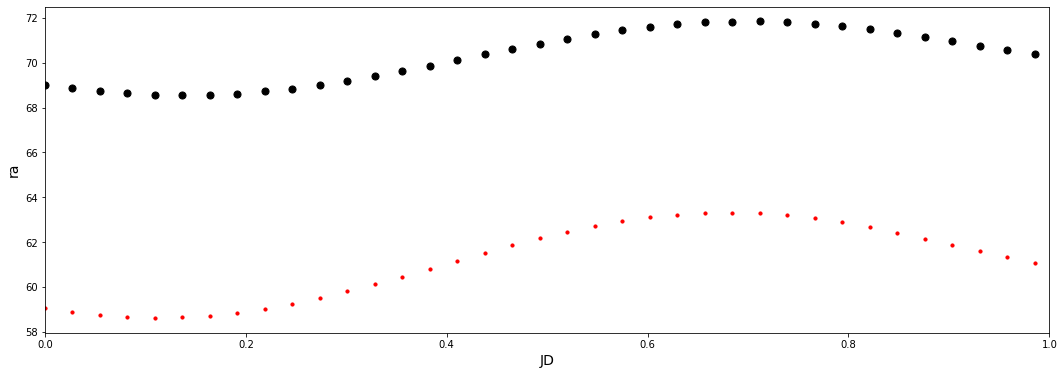

In [46]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter((testdates.jd - testdates.jd[0])/365.25, ephem_Horizons['RA_app'], color='black', s=50)
ax.scatter((testdates.jd - testdates.jd[0])/365.25, np.degrees(restra), color='red', s=10)
ax.set_xlabel('JD', fontsize=14)
ax.set_ylabel('ra', fontsize=14)
ax.set_xlim([0, Nyears]);

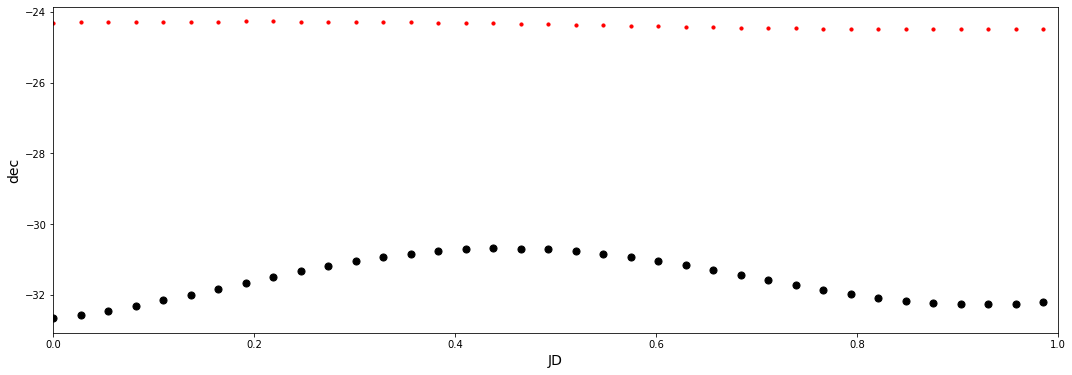

In [16]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter((testdates.jd - testdates.jd[0])/365.25, ephem_Horizons['DEC'], color='black', s=50)
ax.scatter((testdates.jd - testdates.jd[0])/365.25, TNO_predict.dec.deg, color='red', s=10)
ax.set_xlabel('JD', fontsize=14)
ax.set_ylabel('dec', fontsize=14)
ax.set_xlim([0, Nyears]);

---

In [17]:
TNOs = pd.read_json('https://minorplanetcenter.net/Extended_Files/distant_extended.json.gz')

TNOs = TNOs[TNOs.Principal_desig.values.astype(str) == '2015 BP519']
units = Units()
rocks = SpaceRock(a=TNOs.a.values, 
                  e=TNOs.e.values, 
                  inc=TNOs.i.values, 
                  arg=TNOs.Peri.values, 
                  node=TNOs.Node.values, 
                  t_peri=TNOs.Tp.values, 
                  epoch=TNOs.Epoch.values,
                  H=TNOs.H.values, 
                  name=TNOs.Principal_desig.values,
                  #delta_H = np.random.rand(len(TNOs)),
                  #rotation_period = np.random.uniform(0.2, 0.5, len(TNOs)),
                  #phi0 = np.random.rand(len(TNOs)) * 2 * np.pi,
                  input_frame='heliocentric',
                  units=units)

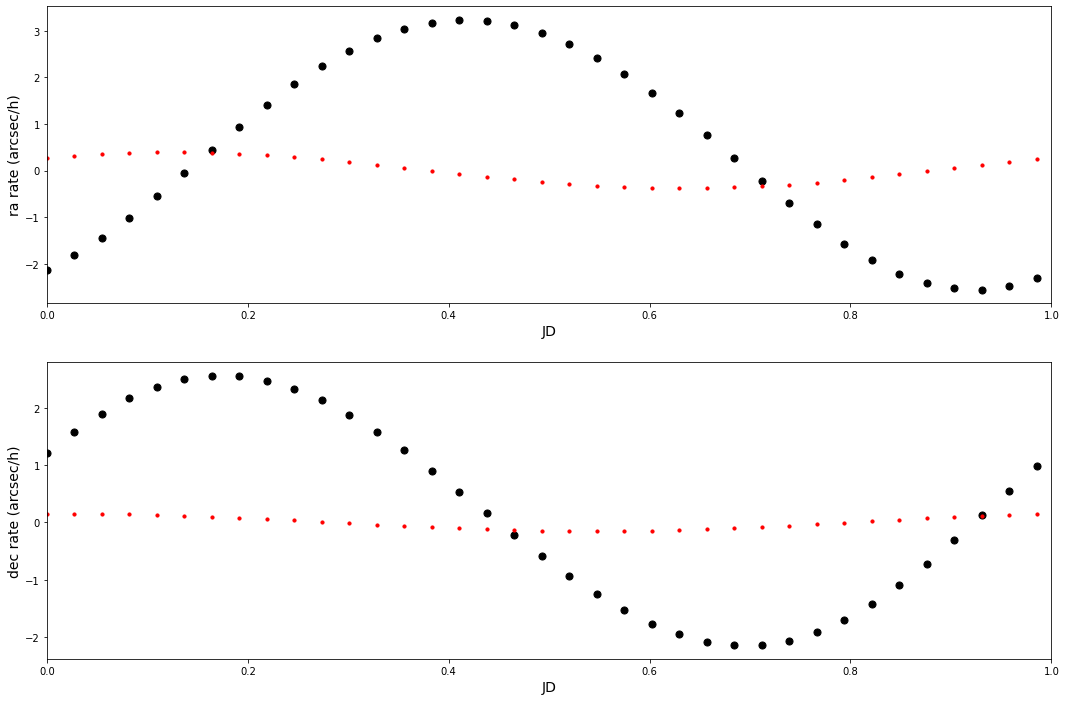

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(18, 12))
ax[0].scatter((testdates.jd - testdates.jd[0])/365.25, ephem_Horizons['RA_rate'], color='black', s=50)
ax[0].scatter((testdates.jd - testdates.jd[0])/365.25, TNO_predict.ra_rate.to(u.arcsec/u.h), color='red', s=10)
ax[0].set_xlabel('JD', fontsize=14)
ax[0].set_ylabel('ra rate (arcsec/h)', fontsize=14)
ax[0].set_xlim([0, Nyears]);

ax[1].scatter((testdates.jd - testdates.jd[0])/365.25, ephem_Horizons['DEC_rate'], color='black', s=50)
ax[1].scatter((testdates.jd - testdates.jd[0])/365.25, TNO_predict.dec_rate.to(u.arcsec/u.h), color='red', s=10)
ax[1].set_xlabel('JD', fontsize=14)
ax[1].set_ylabel('dec rate (arcsec/h)', fontsize=14)
ax[1].set_xlim([0, Nyears]);

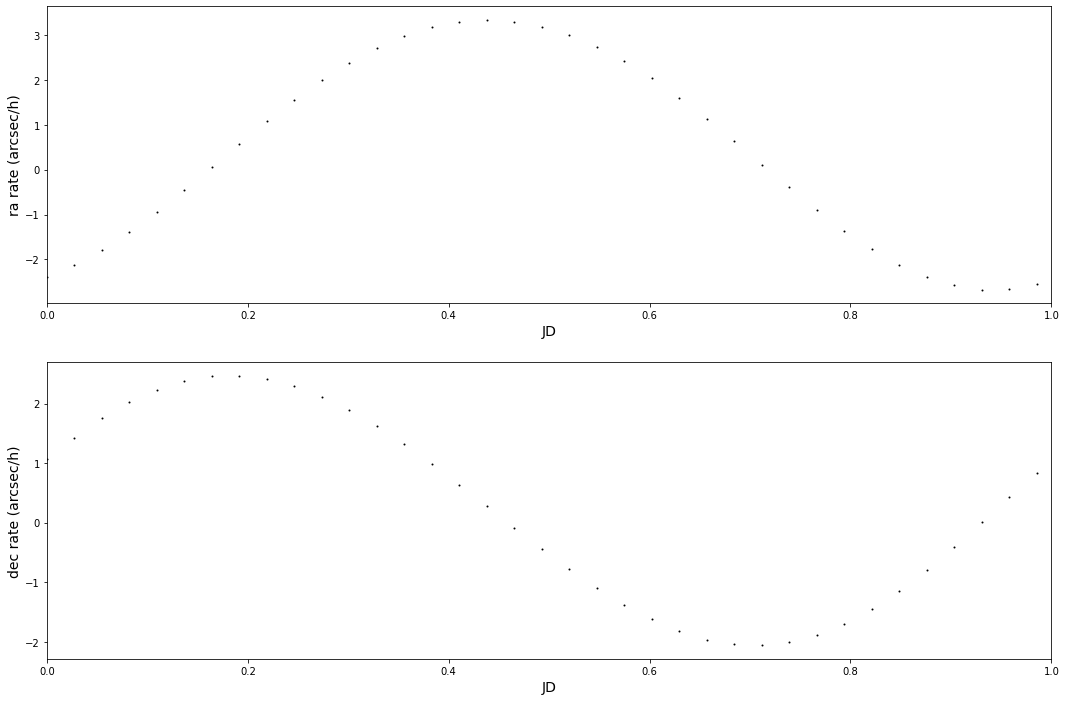

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(18, 12))
ax[0].scatter((testdates.jd - testdates.jd[0])/365.25, 
              ephem_Horizons['RA_rate'] - TNO_predict.ra_rate.to(u.arcsec/u.h), color='black', s=1)
ax[0].set_xlabel('JD', fontsize=14)
ax[0].set_ylabel('ra rate (arcsec/h)', fontsize=14)
ax[0].set_xlim([0, Nyears]);

ax[1].scatter((testdates.jd - testdates.jd[0])/365.25, 
              ephem_Horizons['DEC_rate'] - TNO_predict.dec_rate.to(u.arcsec/u.h), color='black', s=1)
ax[1].set_xlabel('JD', fontsize=14)
ax[1].set_ylabel('dec rate (arcsec/h)', fontsize=14)
ax[1].set_xlim([0, Nyears]);